<h1>California Wildfire Risk Prediction and Electric Grid Failure Analysis</h1>

For this project, the California Wildfire datasets will be utilized to addrees or explore these topics/questions within the Risk Quantification and Data Science domains:

- How would you design a quantitative risk model for wildfire risk assessment using machine learning?
- Can you explain risk quantification methodologies and how you would apply them to PG&E’s electric operations?
- What is your experience with time-series modeling, and how would you use it for predicting power grid failures?
- How would you handle imbalanced datasets when predicting rare high-impact events, like wildfires or outages?
- Explain Monte Carlo simulations and their role in risk quantification.
- How would you improve PG&E’s prioritization models for risk mitigation strategies?

The ML process overview: 

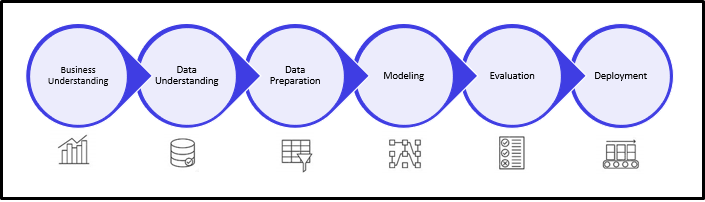

### Import Libraries and Dataset

In [169]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization
import warnings
import missingno as msno

warnings.filterwarnings('ignore') # ignore the annoying warnings kaggle gives

# About Dataset

__Description__: The dataset reflects the damage sustained by structures across various fire incidents, categorized by damage percentage—ranging from minor damage (1-10%) to complete destruction (50-100%) and collected by field inspectors who evaluate structures impacted by wildland fires.

This dataset is invaluable for fire prevention, emergency response, and disaster management efforts.

__Attribute Statement__: This dataset is provided by the California Department of Forestry and Fire Protection (CAL FIRE) in collaboration with the National Interagency Fire Center (NIFC) and the Fire Integrated Real-Time Intelligence System (FIRIS).


Ref: https://www.kaggle.com/datasets/vijayveersingh/the-california-wildfire-data/data




| Original Column Name                 | New Column Name        | Description |
|--------------------------------------|------------------------|-------------|
| **OBJECTID**                         | object_id              | A unique identifier for each record in the dataset. |
| **DAMAGE**                           | damage                 | Indicates the level of fire damage to the structure (e.g., "No Damage", "Affected (1-9%)"). |
| **STREETNUMBER**                     | street_num             | The street number of the impacted structure. |
| **STREETNAME**                       | street_name            | The name of the street where the impacted structure is located. |
| **STREETTYPE**                       | street_type            | The type of street (e.g., "Road", "Lane"). |
| **STREETSUFFIX**                     | street_suffix          | Additional address information, such as apartment or building numbers (if applicable). |
| **CITY**                              | city                   | The city where the impacted structure is located. |
| **STATE**                             | state                  | The state abbreviation (e.g., "CA" for California). |
| **ZIPCODE**                           | zip_code               | The postal code of the impacted structure. |
| **CALFIREUNIT**                       | calfire_unit           | The CAL FIRE unit responsible for the area. |
| **COUNTY**                            | county                 | The county where the impacted structure is located. |
| **COMMUNITY**                         | community              | The community or neighborhood of the structure. |
| **INCIDENTNAME**                      | incident_name          | The name of the fire incident that impacted the structure. |
| **APN**                               | apn                    | The Assessor’s Parcel Number (APN) of the property. |
| **ASSESSEDIMPROVEDVALUE**             | assessed_value         | The assessed value of the improved property (e.g., structures, not just land). |
| **YEARBUILT**                         | year_built             | The year the structure was built. |
| **SITEADDRESS**                       | site_address           | The full address of the property, including city, state, and ZIP code. |
| **GLOBALID**                          | global_id              | A globally unique identifier for each record. |
| **latitude**                          | lat                    | The latitude coordinate of the structure’s location. |
| **longitude**                         | lon                    | The longitude coordinate of the structure’s location. |
| **UTILITYMISCSTRUCTUREDISTANCE**       | dist_utility           | The distance between the main structure and any utility or miscellaneous structures (if recorded). |
| **FIRENAME**                          | fire_name_alt          | An alternative or secondary name for the fire incident. |
| **geometry**                          | geometry               | A geospatial representation of the location in a point format (e.g., "POINT (-13585927.697 4646740.750)"). |


### Notes:
- Some columns, such as **UTILITYMISCSTRUCTUREDISTANCE**, may have missing values when the information could not be determined.
- The **geometry** column provides geospatial data that can be used in mapping applications for visualization.
- This dataset contains a mix of **categorical, numerical, and geospatial data** suitable for analysis and visualization of fire-affected structures.


In [170]:
# Load data
data = '../datasets/b8aeb030-140d-43d2-aa29-1a80862e3d62.csv'
df = pd.read_csv(data, low_memory=False)

In [171]:
df.head(3)

,_id,OBJECTID,* Damage,* Street Number,* Street Name,"* Street Type (e.g. road, drive, lane, etc.)","Street Suffix (e.g. apt. 23, blding C)",* City,State,Zip Code,...,Fire Name (Secondary),APN (parcel),Assessed Improved Value (parcel),Year Built (parcel),Site Address (parcel),GLOBALID,Latitude,Longitude,x,y
0,1,1,No Damage,8376.0,Quail Canyon,Road,NaN,Winters,CA,NaN,...,Quail,0101090290,510000.0,1997.0,8376 QUAIL CANYON RD VACAVILLE CA 95688,e1919a06-b4c6-476d-99e5-f0b45b070de8,38.474960,-122.044465,-1.358593e+07,4.646741e+06
1,2,2,Affected (1-9%),8402.0,Quail Canyon,Road,NaN,Winters,CA,NaN,...,Quail,0101090270,573052.0,1980.0,8402 QUAIL CANYON RD VACAVILLE CA 95688,b090eeb6-5b18-421e-9723-af7c9144587c,38.477442,-122.043252,-1.358579e+07,4.647094e+06
2,3,3,No Damage,8430.0,Quail Canyon,Road,NaN,Winters,CA,NaN,...,Quail,0101090310,350151.0,2004.0,8430 QUAIL CANYON RD VACAVILLE CA 95688,268da70b-753f-46aa-8fb1-327099337395,38.479358,-122.044585,-1.358594e+07,4.647366e+06


<h1>Dataset Exploration</h1>

🔹 __Key Data Processing Steps:__

- Handle Missing Data: Impute or remove null values in fire attributes (size, cause, etc.).
- Date & Time Features: Extract seasonality trends (e.g., summer vs. winter fire frequency).
- Geospatial Analysis: Convert fire locations into latitude-longitude features for mapping risk zones.
- Lag Features: Compute past fire occurrences per region to estimate historical risk.
- Weather Integration: If included, process wind speed, temperature, and humidity as risk factors.
- Categorical Encoding: Convert fire cause types (lightning, arson, powerline failures) into numerical values.

## View summary of dataset

In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100230 entries, 0 to 100229
Data columns (total 47 columns):
 #   Column                                                        Non-Null Count   Dtype  
---  ------                                                        --------------   -----  
 0   _id                                                           100230 non-null  int64  
 1   OBJECTID                                                      100230 non-null  int64  
 2   * Damage                                                      100230 non-null  object 
 3   * Street Number                                               95810 non-null   float64
 4   * Street Name                                                 94744 non-null   object 
 5   * Street Type (e.g. road, drive, lane, etc.)                  87033 non-null   object 
 6   Street Suffix (e.g. apt. 23, blding C)                        44148 non-null   object 
 7   * City                                                  

Several columns contain many null values, which we will have to address before model training. Additionally, many columns contain non-numeric data, which will need to be encoded.

### Get column data types 

In [173]:

dtype_groups = df.dtypes.groupby(df.dtypes)

# Display columns by type
for dtype, cols in dtype_groups:
    print(f"\nColumns of type {dtype}:\n", list(cols.index))


Columns of type int64:
 ['_id', 'OBJECTID']

Columns of type float64:
 ['* Street Number', 'Zip Code', '# Units in Structure (if multi unit)', '# of Damaged Outbuildings < 120 SQFT', '# of Non Damaged Outbuildings < 120 SQFT', 'Assessed Improved Value (parcel)', 'Year Built (parcel)', 'Latitude', 'Longitude', 'x', 'y']

Columns of type object:
 ['* Damage', '* Street Name', '* Street Type (e.g. road, drive, lane, etc.)', 'Street Suffix (e.g. apt. 23, blding C)', '* City', 'State', '* CAL FIRE Unit', 'County', 'Community', 'Battalion', '* Incident Name', 'Incident Number (e.g. CAAEU 123456)', 'Incident Start Date', 'Hazard Type', 'If Affected 1-9% - Where did fire start?', 'If Affected 1-9% - What started fire?', 'Structure Defense Actions Taken', '* Structure Type', 'Structure Category', '* Roof Construction', '* Eaves', '* Vent Screen', '* Exterior Siding', '* Window Pane', '* Deck/Porch On Grade', '* Deck/Porch Elevated', '* Patio Cover/Carport Attached to Structure', '* Fence Attac

#### Standarilize the column names

In [174]:
rename_dict = {
    '_id': 'id',
    'OBJECTID': 'object_id',
    
    '* Street Number': 'street_num',
    'Zip Code': 'zip_code',
    '# Units in Structure (if multi unit)': 'units',
    '# of Damaged Outbuildings < 120 SQFT': 'damaged_outbuildings',
    '# of Non Damaged Outbuildings < 120 SQFT': 'non_damaged_outbuildings',
    'Assessed Improved Value (parcel)': 'assessed_value',
    'Year Built (parcel)': 'year_built',
    'Latitude': 'latitude',
    'Longitude': 'longitude',
    'x': 'x_coord',
    'y': 'y_coord',
    
    '* Damage': 'damage',
    '* Street Name': 'street_name',
    '* Street Type (e.g. road, drive, lane, etc.)': 'street_type',
    'Street Suffix (e.g. apt. 23, blding C)': 'street_suffix',
    '* City': 'city',
    'State': 'state',
    '* CAL FIRE Unit': 'calfire_unit',
    'County': 'county',
    'Community': 'community',
    'Battalion': 'battalion',
    '* Incident Name': 'incident_name',
    'Incident Number (e.g. CAAEU 123456)': 'incident_num',
    'Incident Start Date': 'incident_date',
    'Hazard Type': 'hazard_type',
    'If Affected 1-9% - Where did fire start?': 'fire_origin',
    'If Affected 1-9% - What started fire?': 'fire_cause',
    'Structure Defense Actions Taken': 'defense_actions',
    '* Structure Type': 'structure_type',
    'Structure Category': 'structure_category',
    '* Roof Construction': 'roof',
    '* Eaves': 'eaves',
    '* Vent Screen': 'vent_screen',
    '* Exterior Siding': 'siding',
    '* Window Pane': 'window',
    '* Deck/Porch On Grade': 'deck_grade',
    '* Deck/Porch Elevated': 'deck_elevated',
    '* Patio Cover/Carport Attached to Structure': 'patio_carport',
    '* Fence Attached to Structure': 'fence_attached',
    'Distance - Propane Tank to Structure': 'dist_propane',
    'Distance - Residence to Utility/Misc Structure &gt; 120 SQFT': 'dist_utility',
    'Fire Name (Secondary)': 'fire_name_alt',
    'APN (parcel)': 'apn',
    'Site Address (parcel)': 'site_address',
    'GLOBALID': 'global_id'
}

# Rename columns
df.rename(columns=rename_dict, inplace=True)


### Check Null data

In [175]:
df.isnull().sum()

id                              0
object_id                       0
damage                          0
street_num                   4420
street_name                  5486
street_type                 13197
street_suffix               56082
city                        31614
state                           7
zip_code                    52801
calfire_unit                    0
county                         30
community                   47338
battalion                   93832
incident_name                   0
incident_num                    0
incident_date                   0
hazard_type                     0
fire_origin                 89490
fire_cause                  91214
defense_actions             75760
structure_type                  0
structure_category              0
units                       69046
damaged_outbuildings        69145
non_damaged_outbuildings    69157
roof                          628
eaves                        1112
vent_screen                  1198
siding        

### Visualize the missing data

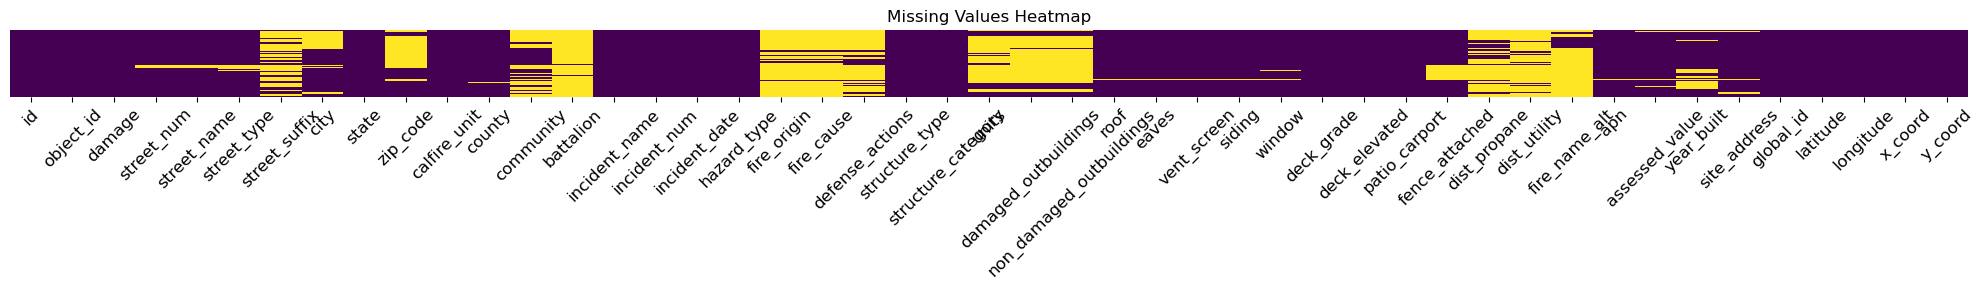

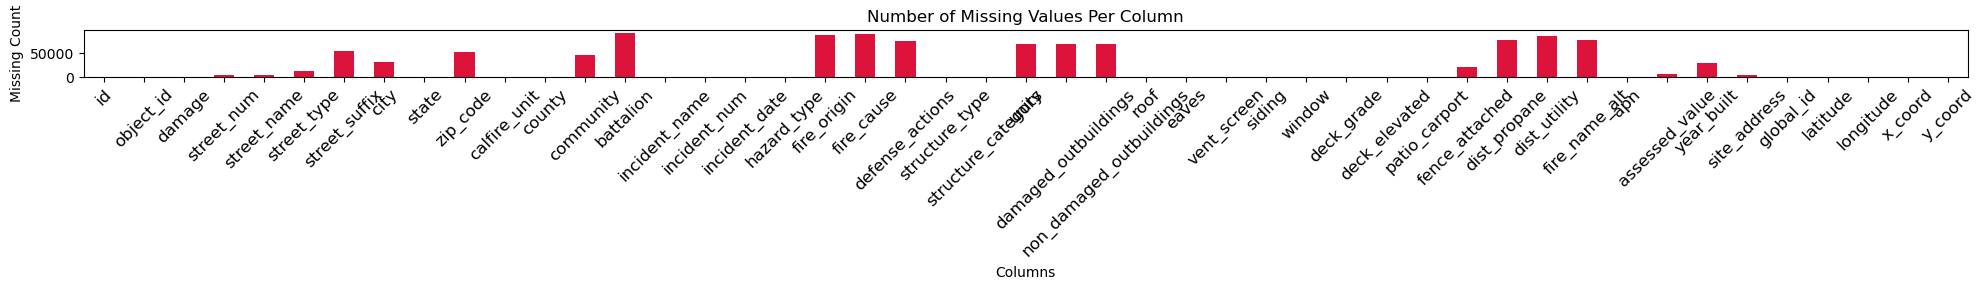

In [176]:
# Heatmap of missing values
plt.figure(figsize=(20, 3))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

# Bar chart of missing values per column
df.isnull().sum().plot(kind='bar', figsize=(20, 3), color='crimson')
plt.title("Number of Missing Values Per Column")
plt.xlabel("Columns")
plt.ylabel("Missing Count")
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

In [177]:
# View first three columns of dataset
df.head(3).T

,0,1,2
id,1,2,3
object_id,1,2,3
damage,No Damage,Affected (1-9%),No Damage
street_num,8376.0,8402.0,8430.0
street_name,Quail Canyon,Quail Canyon,Quail Canyon
street_type,Road,Road,Road
street_suffix,NaN,NaN,NaN
city,Winters,Winters,Winters
state,CA,CA,CA
zip_code,NaN,NaN,NaN


In [178]:
# View dimensions of dataset
x = df.shape
print( f"This dataset has {x[0]} instances and {x[1]} features." ) 

This dataset has 100230 instances and 47 features.


<h1>Data Analysis</h1>

I have a few questions about the data:
- What does the correlation between numerical values look like?
- How do different factors influence the value of a property?
- How does damage differ by city?
- How does damage differ by defensive actions taken?
- What does the geographical distribution of damage look like?


<h3>What does the correlation between numerical values look like?</h3>

Text(0.5, 1.0, 'Numerical columns correlation heatmap')

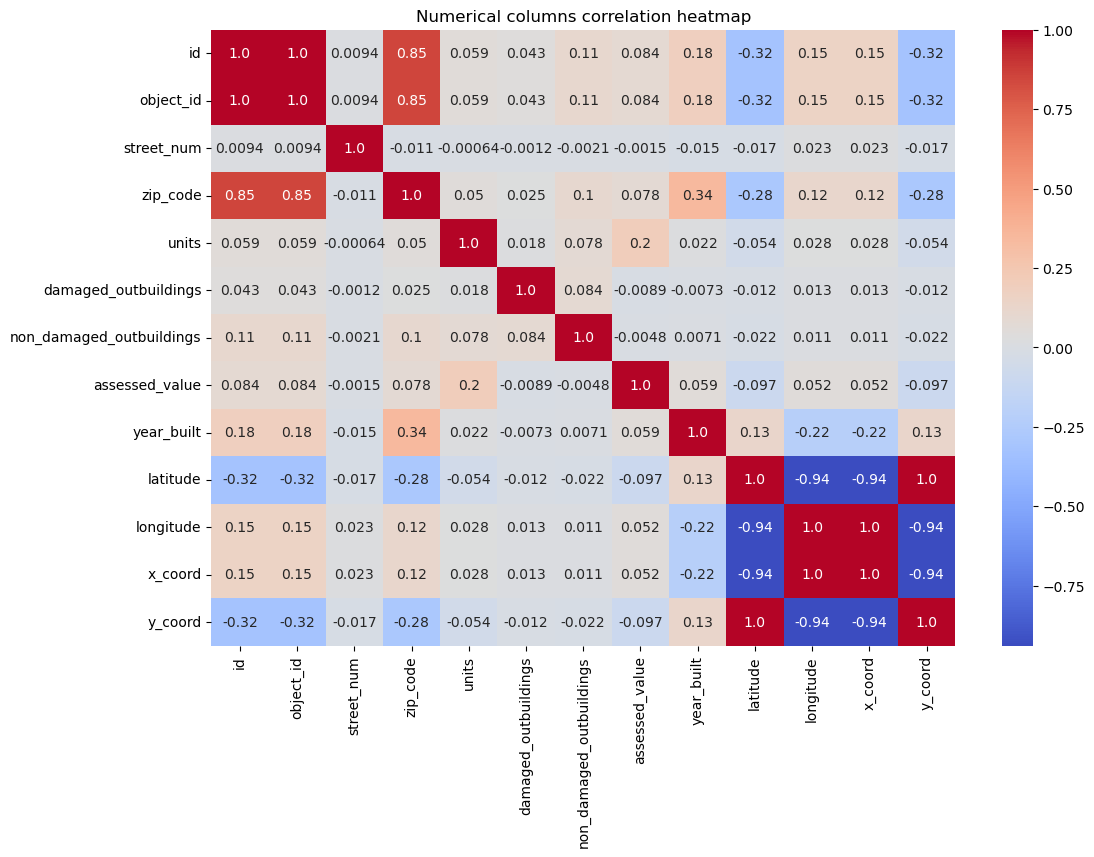

In [179]:
# Select numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64'])

# Drop null values
numeric_cols = numeric_cols.dropna()

# Create corallation matrix
corr_matrix = numeric_cols.corr()

# Visualize with a sns heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap = 'coolwarm', fmt = '0.2')
plt.title('Numerical columns correlation heatmap')

As expected, unique identifiers have a perfect or very high correlation. A few other interesting relationships stand out:
- There is a STRONG negative correlation between longitude and latitude!
- There is a positive correlation between the number of units in a structure and the value of that property
- There is a correlation between zip code and year built
- There is a correlation between year built and longitude and latitude
- There is a negative correlation between year built and longitude and a positive one between year built and latitude
- There is a correlation between ID of the damage report and longitude, latitude and year built

The strong negative correlation between longitude and latitude is explained by the shape of California:

#### Plot longitude v latitude


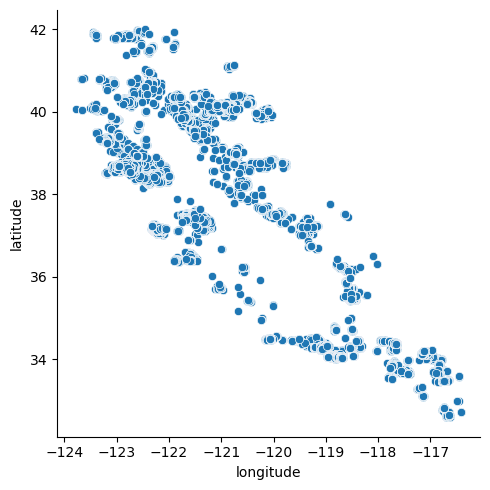

In [180]:
sns.relplot(data = df, x = 'longitude', y = 'latitude');

California is approximately a line with a negative slope!

<h3>How do different factors influence the value of a property?</h3>

Many of the correlations found in the correlation matrix were related to the value of the property. Let's represent that data is a nicer way.

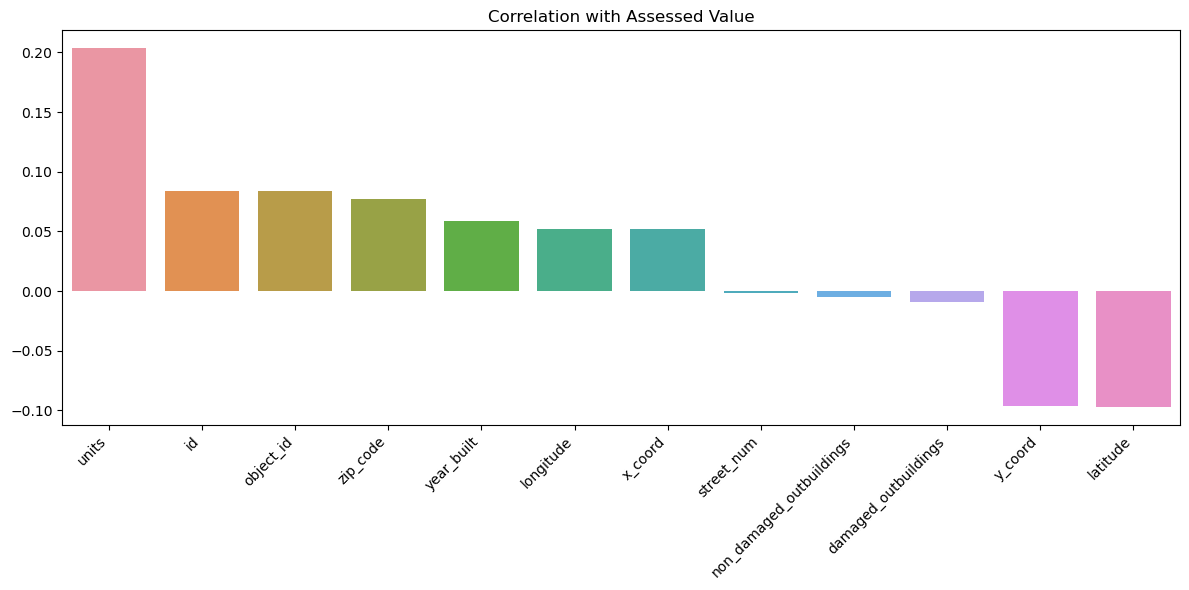

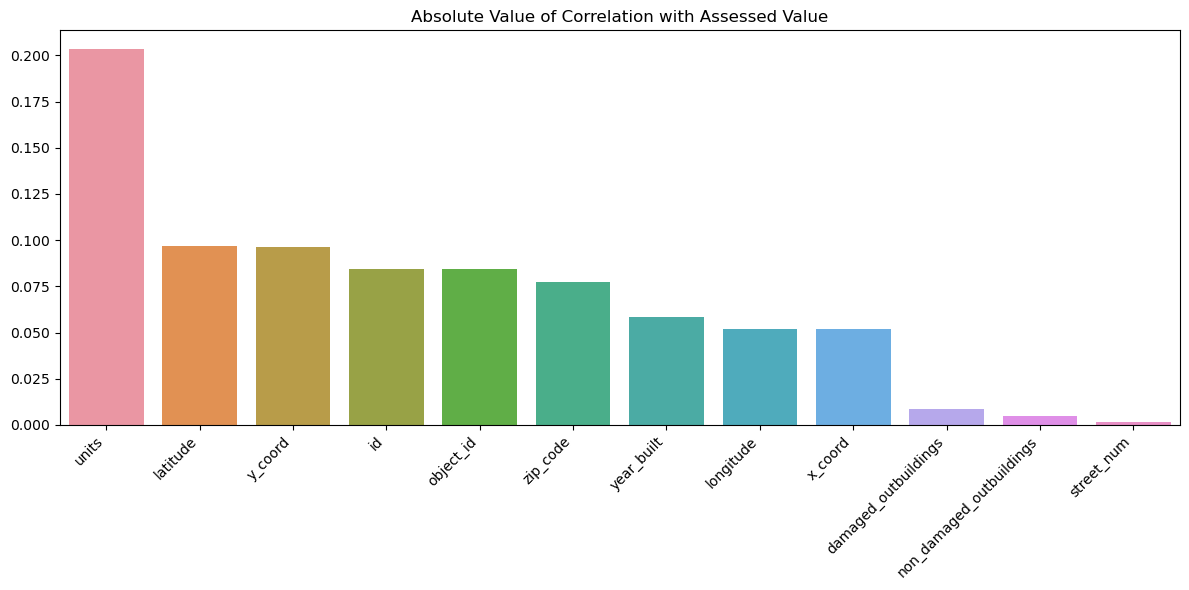

In [181]:
# Remove the correlation with itself (which is always 1)
column_correlations = corr_matrix['assessed_value'].drop('assessed_value')

# Create figure
# Sort correlations in descending order
column_correlations = column_correlations.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=column_correlations.index, y=column_correlations.values)
plt.title(f'Correlation with Assessed Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Create figure with absolute correlation values
plt.figure(figsize=(12, 6))
column_correlations = column_correlations.abs().sort_values(ascending=False)
sns.barplot(x=column_correlations.index, y=column_correlations.values)
plt.title(f'Absolute Value of Correlation with Assessed Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


As we found in our correlation matrix analysis, the value of a property is positively correlated to:
- The number of units in the structure (apartment buildings are worth more than houses)
- The year the building was constructed (newer buildings are worth more)
- longitude (Eastern buildings are worth more)
- ID (no idea why, probably due to ID's correlation with other factors)
- Zip code (no idea why, probably to Zip code's correlation with other factors)

And negatively correlated to:
- latitude (Northern buildings are worth less, southern buildings are worth more)

<h3>How does damage differ by city?</h3>

Let's start by plotting the distribution of damage types:

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'No Damage'),
  Text(1, 0, 'Affected (1-9%)'),
  Text(2, 0, 'Minor (10-25%)'),
  Text(3, 0, 'Destroyed (>50%)'),
  Text(4, 0, 'Major (26-50%)'),
  Text(5, 0, 'Inaccessible')])

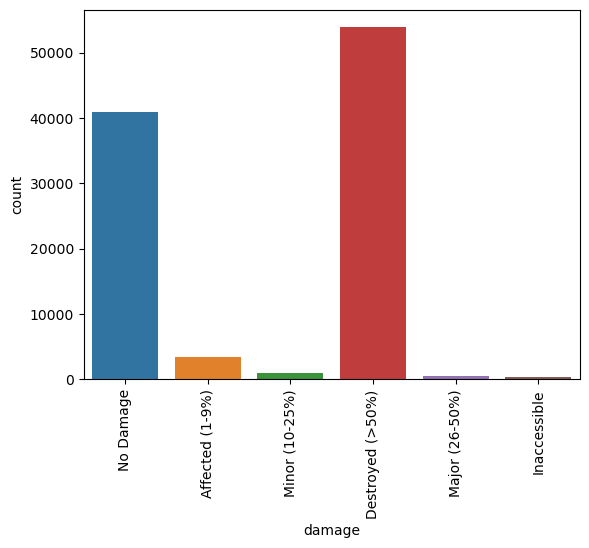

In [182]:
sns.countplot(data = df, x = 'damage')
plt.xticks(rotation = 90)

It appears that there are very few buildings which suffered minor or major damage. We will bin this data into three categories: No Damage, Affected (which will include the current categories of affected, minor and major damage), and Destroyed.

In [183]:
df = df[df['damage'] != 'Inaccessible']
df['damage'] = df['damage'].replace(['Minor (10-25%)', 'Major (26-50%)'], 'Affected')
df['damage'] = df['damage'].replace(['Affected (1-9%)'], 'Affected')
df['damage'] = df['damage'].replace(['Destroyed (>50%)'], 'Destroyed')

(array([0, 1, 2]),
 [Text(0, 0, 'No Damage'), Text(1, 0, 'Affected'), Text(2, 0, 'Destroyed')])

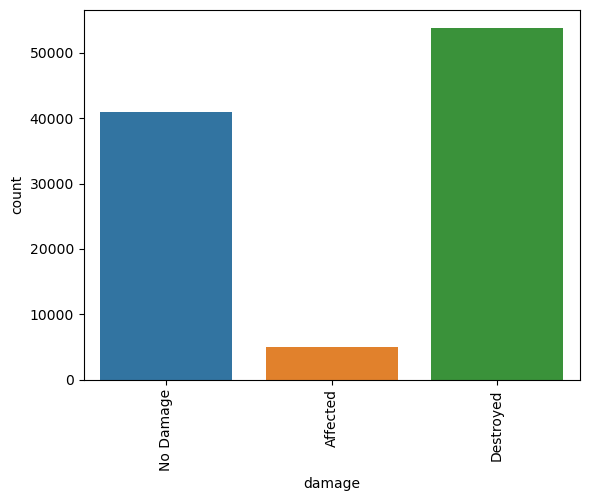

In [184]:
sns.countplot(data = df, x = 'damage')
plt.xticks(rotation = 90)

Much better. This new categorization will serve us well both in our data analysis and in our upcoming model training! I did not simply bin the data into two categories (Undamaged vs Damaged) because of the imaginary use case of the model: predicting for an individual the damage their home will suffer. I feel that being told your home will be Destroyed, Affected or Undamaged is more motivating and actionable than simply being told that your home will either be Damaged or Undamaged, without any indication of the extent of the harm. 

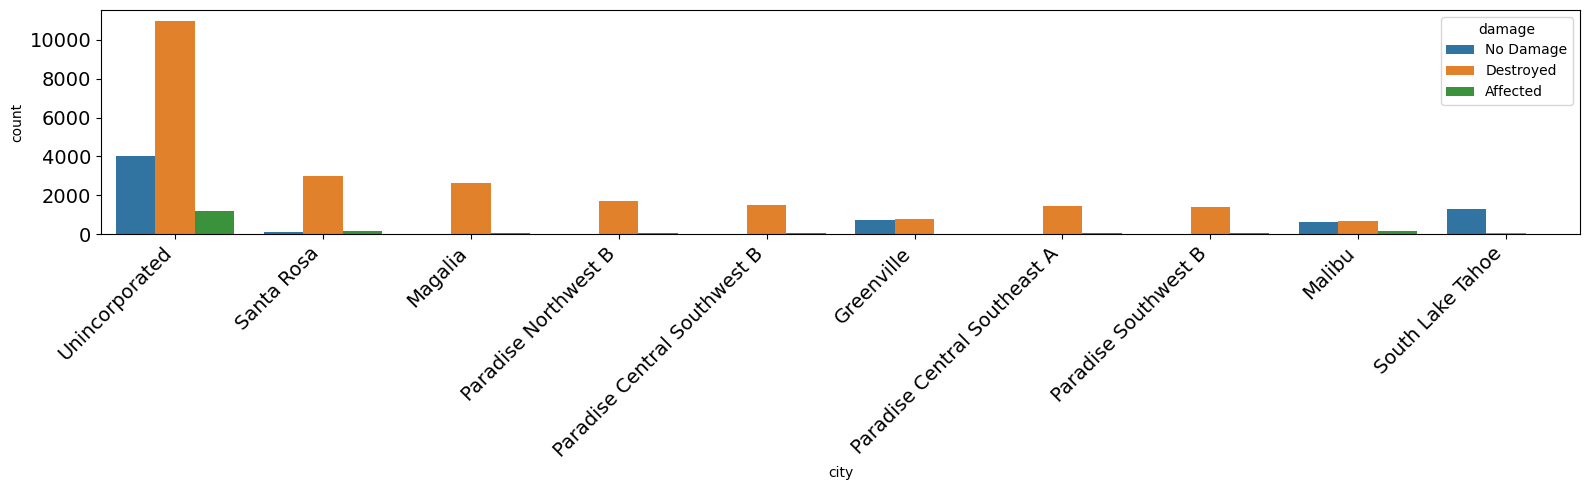

In [185]:
# Get top 10 cities by frequency and sort from most to least
top_cities = df['city'].value_counts().head(10)

# Create countplot with cities ordered from most to least
plt.figure(figsize=(16, 5))
sns.countplot(data=df[df['city'].isin(top_cities.index)], 
             x='city', 
             hue='damage', 
             order=top_cities.index)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

This graph shows that out of every city, there are the most buildings which are 'Unincorporated'. The interesting insights come in comparing cities:
Buildings in Magalia were almost always destroyed, whereas buildings in Grenville had a 50/50 shot of being destroyed or unaffected, and buildings in South Lake Tahoe were almost always totally OK. 


<h3>How does damage differ by defensive actions taken?</h3>

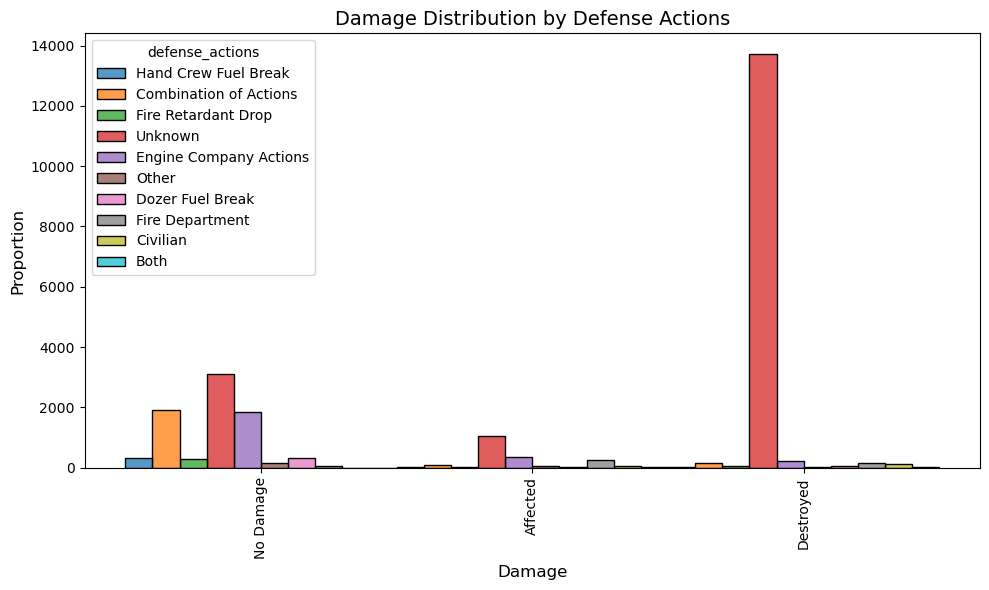

In [186]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x ='damage', hue ="defense_actions", multiple="dodge")
plt.title('Damage Distribution by Defense Actions', fontsize=14)
plt.xlabel('Damage', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

From this graph, it is clear that undamaged and affected buildings took a variety of actions, whereas Destroyed buildings overwhelmingly took 'Unknown' (no?) action.

<h3>What does the geographical distribution of damage look like?</h3>

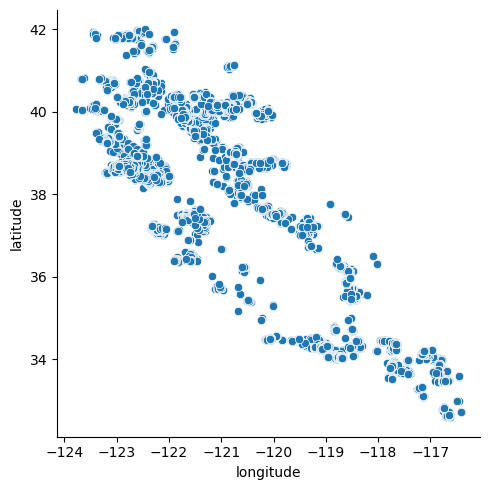

In [187]:
# Plot longitude v latitude
sns.relplot(data = df, x = 'longitude', y = 'latitude')

Although this graph reveals the linear nature of California beautifully, and shows the distribution of buildings **surveyed**, it does not give helpful insight into where in the state more houses were **destroyed**. What we really want is a map that will tell us where the fires were better and where they were worse.

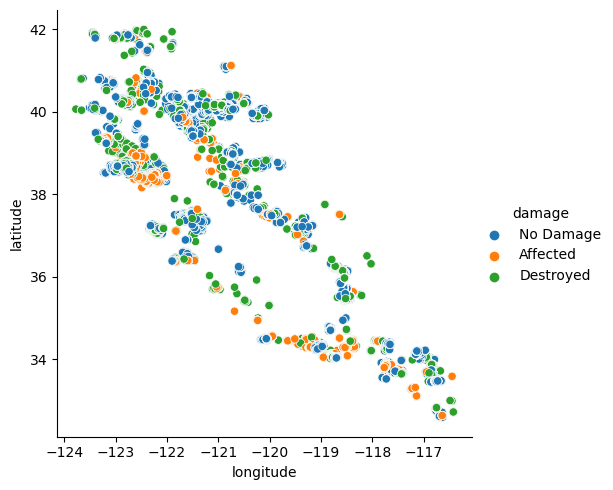

In [188]:
# Plot longitude v latitude, hue = Damage
sns.relplot(data = df, x = 'longitude', y = 'latitude', hue = 'damage');

This is useful, but in some regions with many buildings still does not provide what we want. The ideal graph here would be a heatmap where each zone's colour corresponds to the ration of the destroyed buildings in the area.

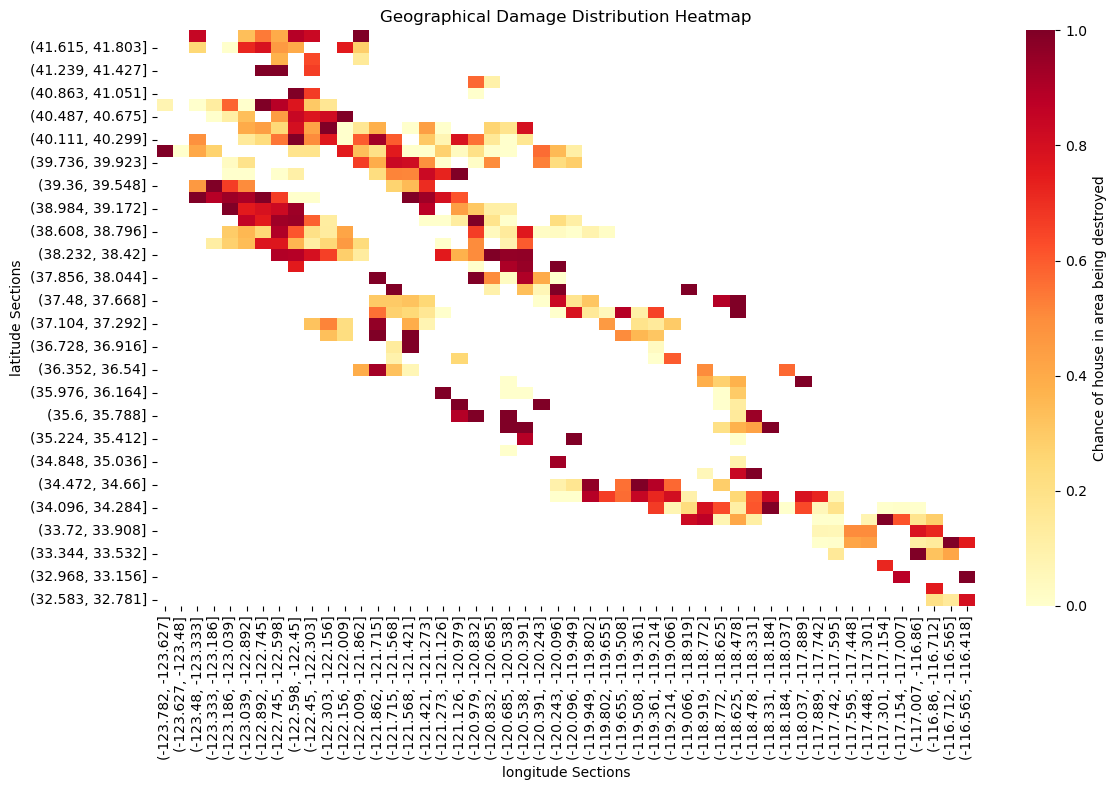

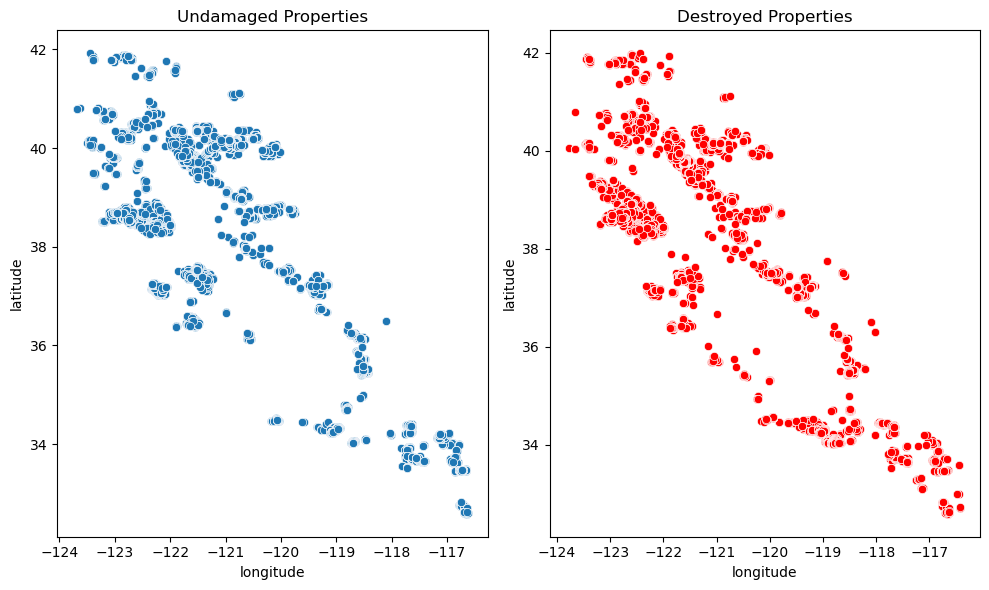

In [189]:
def analyze_damage_distribution(df, num_sections=50):
    """
    Analyze damage distribution across geographical sections
    
    Parameters:
    - df: DataFrame containing damage and location data
    - num_sections: Number of sections to divide longitude and latitude into
    
    Returns:
    - DataFrame with damage ratios for each geographical section
    """
    # Create longitude and latitude bins
    df['long_bin'] = pd.cut(df['longitude'], bins=num_sections)
    df['lat_bin'] = pd.cut(df['latitude'], bins=num_sections)
    
    # Group by geographical sections and calculate damage ratio
    damage_distribution = df.groupby(['long_bin', 'lat_bin']).apply(
        lambda x: pd.Series({
            'damage_ratio': len(x[x['damage'] == 'Destroyed']) / len(x)
        })
    ).reset_index()
    
    return damage_distribution

def visualize_damage_heatmap(damage_distribution):
    """
    Create a heatmap of damage ratios
    
    Parameters:
    - damage_distribution: DataFrame with damage distribution data
    """
    plt.figure(figsize=(12, 8))
    pivot_data = damage_distribution.pivot(
        index='lat_bin', 
        columns='long_bin', 
        values='damage_ratio'
    )
    
    sns.heatmap(
        pivot_data, 
        cmap='YlOrRd', 
        annot=False, 
        fmt='.2f', 
        cbar_kws={'label': 'Chance of house in area being destroyed'}
    )
    plt.title('Geographical Damage Distribution Heatmap')
    plt.xlabel('longitude Sections')
    plt.ylabel('latitude Sections')
    plt.tight_layout()
    plt.gca().invert_yaxis()
    plt.show()

def plot_damage_distributions(df):
    """
    Plot geographical distributions of undamaged and damaged properties
    
    Parameters:
    - df: DataFrame containing damage and location data
    """
    # Undamaged properties
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    sns.scatterplot(
        data=df[df['damage'] == 'No Damage'], 
        x='longitude', 
        y='latitude'
    )
    plt.title('Undamaged Properties')
    
    # Damaged properties
    plt.subplot(1, 2, 2)
    sns.scatterplot(
        data=df[df['damage'] == 'Destroyed'], 
        x='longitude', 
        y='latitude', 
        color='red'
    )
    plt.title('Destroyed Properties')
    plt.tight_layout()
    plt.show()

damage_dist = analyze_damage_distribution(df)
visualize_damage_heatmap(damage_dist)
plot_damage_distributions(df)

<h1>Model Training!</h1>

I will now train a random forest model to predict the damage a house will suffer based only on information that would be available before a fire started. 

<h1>1. Data cleaning and parameter selection</h1>

All columns which contain repeated information (eg. many redundant unique identifiers), have too few entries or contain info that would not be available before a fire began will be dropped.

In [190]:
df.columns

Index(['id', 'object_id', 'damage', 'street_num', 'street_name', 'street_type',
       'street_suffix', 'city', 'state', 'zip_code', 'calfire_unit', 'county',
       'community', 'battalion', 'incident_name', 'incident_num',
       'incident_date', 'hazard_type', 'fire_origin', 'fire_cause',
       'defense_actions', 'structure_type', 'structure_category', 'units',
       'damaged_outbuildings', 'non_damaged_outbuildings', 'roof', 'eaves',
       'vent_screen', 'siding', 'window', 'deck_grade', 'deck_elevated',
       'patio_carport', 'fence_attached', 'dist_propane', 'dist_utility',
       'fire_name_alt', 'apn', 'assessed_value', 'year_built', 'site_address',
       'global_id', 'latitude', 'longitude', 'x_coord', 'y_coord', 'long_bin',
       'lat_bin'],
      dtype='object')

In [196]:
df = df.drop(['object_id',
              'id',
              'street_suffix',
              'state',
              'zip_code',
              'community',
              'battalion',
              'incident_num',
              'hazard_type',
              'fire_name_alt',
              'dist_utility',
              'apn',
              'dist_propane',
              'global_id',
              'site_address',
              'units',
              'structure_type',
              'fence_attached',
              'x_coord',
              'y_coord',
              'city',
              'incident_name',
              'incident_date',
              'fire_origin',
              'fire_cause',
              'damaged_outbuildings',
              'non_damaged_outbuildings'
             ], axis=1)


With that done, we recall that the structural defence actions column had many null values. We assume that a null value means no action was taken, and fill it with "None".

In [197]:
# Make Structure defense NaNs into 'None'
df['defense_actions'] = df['defense_actions'].fillna('None')

# Drop all rows with missing values
df = df.dropna()

Let's take a look at our cleaned data. This will be what our model is trained on.

In [198]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58971 entries, 0 to 100229
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   damage              58971 non-null  object  
 1   street_num          58971 non-null  float64 
 2   street_name         58971 non-null  object  
 3   street_type         58971 non-null  object  
 4   calfire_unit        58971 non-null  object  
 5   county              58971 non-null  object  
 6   defense_actions     58971 non-null  object  
 7   structure_category  58971 non-null  object  
 8   roof                58971 non-null  object  
 9   eaves               58971 non-null  object  
 10  vent_screen         58971 non-null  object  
 11  siding              58971 non-null  object  
 12  window              58971 non-null  object  
 13  deck_grade          58971 non-null  object  
 14  deck_elevated       58971 non-null  object  
 15  patio_carport       58971 non-null  obje

In [199]:
df.head()

,damage,street_num,street_name,street_type,calfire_unit,county,defense_actions,structure_category,roof,eaves,...,window,deck_grade,deck_elevated,patio_carport,assessed_value,year_built,latitude,longitude,long_bin,lat_bin
0,No Damage,8376.0,Quail Canyon,Road,LNU,Solano,None,Single Residence,Asphalt,Unenclosed,...,Single Pane,Wood,Wood,No Patio Cover/Carport,510000.0,1997.0,38.474960,-122.044465,"(-122.156, -122.009]","(38.42, 38.608]"
1,Affected,8402.0,Quail Canyon,Road,LNU,Solano,Hand Crew Fuel Break,Single Residence,Asphalt,Unenclosed,...,Multi Pane,Masonry/Concrete,No Deck/Porch,No Patio Cover/Carport,573052.0,1980.0,38.477442,-122.043252,"(-122.156, -122.009]","(38.42, 38.608]"
2,No Damage,8430.0,Quail Canyon,Road,LNU,Solano,None,Single Residence,Asphalt,Enclosed,...,Single Pane,No Deck/Porch,No Deck/Porch,No Patio Cover/Carport,350151.0,2004.0,38.479358,-122.044585,"(-122.156, -122.009]","(38.42, 38.608]"
3,No Damage,3838.0,Putah Creek,Road,LNU,Solano,None,Single Residence,Asphalt,Unenclosed,...,Single Pane,No Deck/Porch,No Deck/Porch,Combustible,134880.0,1981.0,38.487313,-122.015115,"(-122.156, -122.009]","(38.42, 38.608]"
4,No Damage,3830.0,Putah Creek,Road,LNU,Solano,None,Single Residence,Tile,Enclosed,...,Multi Pane,Wood,Wood,Combustible,346648.0,1980.0,38.485636,-122.016122,"(-122.156, -122.009]","(38.42, 38.608]"


We will be training our model on 60,000 cases, each described by 22 parameters. No null values are left in our data.

<h1>2. Divide into X and y, and train test split, encode and scale</h1>

The last two things we need to do before we can train our model is to convert every piece of data into numbers and split our data into training and testing sets. We encode non-numeric data with sklearn's OneHot encoder and scale numeric data with StandardScaler so that it does not have an outsized effect on the model.

In [200]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Divide into X and y and encode y (label encoder because ordinal)
le = LabelEncoder()
y = le.fit_transform(df['damage'])
X = df.drop(['damage'], axis=1)

# Divide X data into numerical and catagorical
numerical_col = X.select_dtypes(include = 'float64').columns.tolist()
catagorical_col = X.select_dtypes(exclude = 'float64').columns.tolist()

# Split data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

# Create preprocessing steps for numerical and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_col),
        ('cat', OneHotEncoder(handle_unknown='ignore'), catagorical_col)
    ])

# Do preprocessing 
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

<h1>3. Train a random forest model!</h1>

Now it is time to train our model!

In [201]:
# Import Random Forest classifier

from sklearn.ensemble import RandomForestClassifier


# Instantiate the classifier 

rfc = RandomForestClassifier(random_state=42)


# Fit the model

rfc.fit(X_train, y_train)


# Predict the Test set results

y_pred = rfc.predict(X_test)


# Check accuracy score 

from sklearn.metrics import accuracy_score

print('Model accuracy: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy: 0.9182


92% Accuracy!

<h1>4. Evaluate the model</h1>

Finally, we evaluate the model to see which characteristics it weighed most highly and take a look at the confusion matrix.

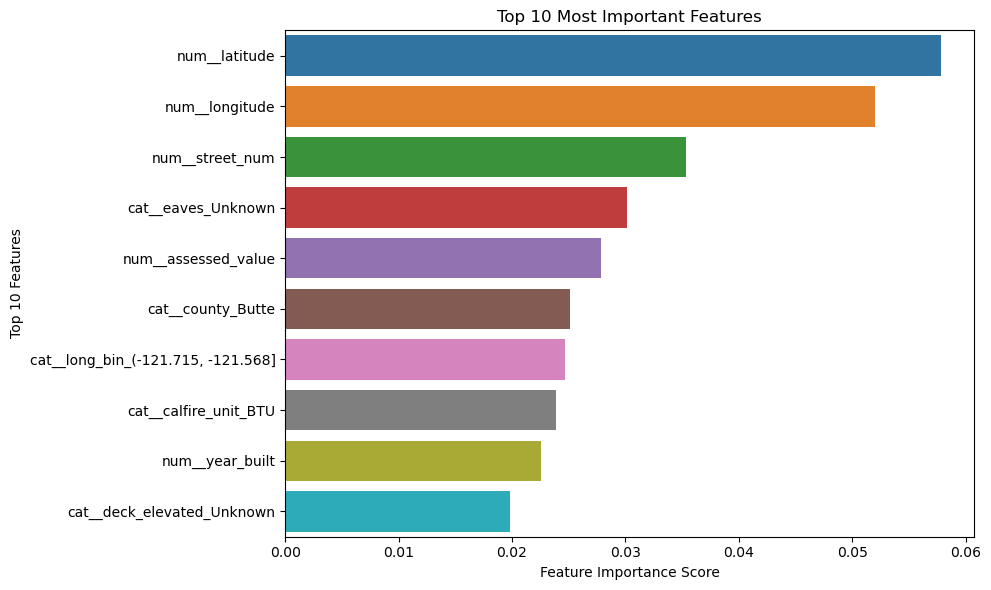

<Figure size 1000x800 with 0 Axes>

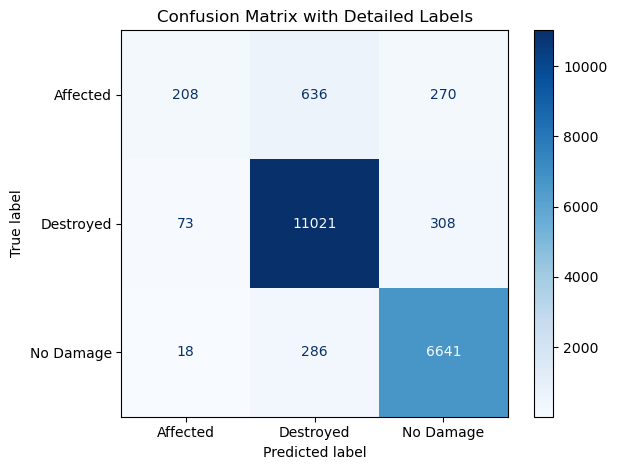

In [202]:
# Get feature names
feature_names = preprocessor.get_feature_names_out()

# Calculate feature scores
feature_scores = pd.Series(rfc.feature_importances_, index=feature_names).sort_values(ascending=False)

# Select top 10 most influential features
top_10_features = feature_scores.head(10)

# Create bar plot for top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_features.values, y=top_10_features.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Top 10 Features')
plt.title("Top 10 Most Important Features")
plt.tight_layout()
plt.show()

# Confusion Matrix with labels
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_labels = le.classes_

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix with Detailed Labels')
plt.tight_layout()
plt.show()